In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def tau(u):
    '''
    Function for tau.
    
    Params:
        u - (array-like) Random, uniformly distributed variable
    Returns:
        - (array-like) Value(s) of tau
    ''' 
    return -np.log(1-u)

def mu(u):
    '''
    Function for mu.
    
    Params:
        u - (array-like) Random, uniformly distributed variable
    Returns:
        - (array-like) Value(s) of mu
    ''' 
    return 2*u-1

def phi(u):
    '''
    Function for phi.
    
    Params:
        u - (array-like) Random, uniformly distributed variable
    Returns:
        - (array-like) Value(s) of phi
    ''' 
    return 2*np.pi*u

In [3]:
def intensity(exited, N_mu=20):
    '''
    Calculates the intensity of the exiting photons with particular groups
    of exiting angles. Formula defined in lab manual.
    
    Params:
        exited - (array) Mu values of exited photons
        N_mu - (int) Optional. Number of bins
    Returns:
        bin_size - (array) Number of photons in each bin
        intensities - (array) Intensities of each bin
        thetas - (array) exiting angle of each bin
    ''' 
    N_0 = exited.size
    bin_size, intensities, thetas = np.empty(N_mu), np.empty(N_mu), np.empty(N_mu)
    intervals = np.linspace(0,1,N_mu + 1)
    
    for i in range(N_mu):
        # Mask for all photons that are inside selected bin values
        mask = (exited < intervals[i+1]) & (exited > intervals[i])
        
        # Number of points in bin
        bin_size[i] = exited[mask].size 
        
        # Median exit angle of photon bin
        mu_i = (intervals[i+1] - intervals[i])/2 + intervals[i]
        
        intensities[i] = bin_size[i]/2/N_mu/mu_i #intensity
        thetas[i] = np.arccos(mu_i) #exit angle
        
    return bin_size, intensities, thetas

def theoretical_intensity(theta):
    '''
    Theoretical intensity curve given by literature values.
    
    Params:
        theta - (array-like) Theta values of photons
    Returns:
        - (array-like) Intensities of photons photons 
    '''
    return 0.0244*(51.6-0.0043*theta**2)

def RT(m, p, z_max=1, tau_max=10, prob=1, nsteps=100, bins=20, verbose=False):
    '''
    Radiative transfer simulation. Takes the initial mu and phi values for
    an arbitrary number of photons as they enter a slab of material, and
    the simulates their path through the material.
    
    ***This full version keeps track of all three coordinates. This
    isn't actually used in this file for effeciency reasons, but is still 
    useful in some cases so was included.
    
    Params:
        m - (array-like) Initial mu values of photons
        p - (array-like) Initial phi values of photons
        z_max - (float) Optional. Top of slab
        tau_max - (float) Optional. Maximum jump length for photons
        prob - (float) Optional. Between zero and 1. Probability of a scattering vs.
                        being absorbed
        nsteps - (int) Optional. Number of iterations to simulate photons for
        verbose - (bool) Optional. Set to true to generate histogram of photon intensity
    Returns:
        - (array-like) Mu values of exited photons
    '''
    # Initial position arrays
    x, y, z = np.zeros(*m.shape), np.zeros(*m.shape), np.zeros(*m.shape)
    mu_exited = np.empty(0)

    for i in range(nsteps):
        # Simulate depth and angle of penetration
        t = tau(np.random.rand(*m.shape))
        L = t*z_max/tau_max
        theta = np.arccos(m)
        
        # Update coordinates of each particle
        x = x + L*np.sin(theta)*np.cos(p)
        y = y + L*np.sin(theta)*np.sin(p)
        z = z + L*np.cos(theta)
        
        # Mask out photons that have exited
        exited_mask = z > z_max
        if np.sum(exited_mask) > 0: mu_exited = np.append(mu_exited, m[exited_mask])
        
        # Mask out invalid photons and respawn them
        dead_mask = np.random.rand(*m.shape) <= prob
        dead_mask |= exited_mask 
        dead_mask |= z < 0
        
        x[dead_mask] = 0
        y[dead_mask] = 0
        z[dead_mask] = 0
        
        # Update mu and phi values
        m, p = mu(np.random.rand(*m.shape)), phi(np.random.rand(*m.shape))
        
    if verbose:
        plt.hist(mu_exited, color="#ffb759", ec='black', bins=50)
        plt.show()

    return mu_exited

def RT_optimized(m, p, z_max=1, tau_max=10, prob=1, nsteps=100, bins=20, verbose=False):
    '''
    Radiative transfer simulation. Takes the initial mu and phi values for
    an arbitrary number of photons as they enter a slab of material, and
    the simulates their path through the material.
    
    ***This is an opitimised version of RT. Use for larger calculations where
    only the exit angles are of consequence.
    
    Params:
        m - (array-like) Initial mu values of photons
        p - (array-like) Initial phi values of photons
        z_max - (float) Optional. Top of slab
        tau_max - (float) Optional. Maximum jump length for photons
        prob - (float) Optional. Between zero and 1. Probability of a scattering vs.
                        being absorbed
        nsteps - (int) Optional. Number of iterations to simulate photons for
        verbose - (bool) Optional. Set to true to generate histogram of photon intensity
    Returns:
        - (array-like) Mu values of exited photons
    '''
    # Initial position arrays
    z = np.zeros(*m.shape)
    mu_exited = np.empty(0)

    for i in range(nsteps):
        # Simulate depth and angle of penetration
        t = tau(np.random.rand(*m.shape))
        L = t*z_max/tau_max
        theta = np.arccos(m)
        
        # Update position
        z = z + L*np.cos(theta)

        # Mask out photons that have exited
        exited_mask = z > z_max
        if np.sum(exited_mask) > 0: mu_exited = np.append(mu_exited, m[exited_mask])
        
        # Mask out invalid photons and respawn them
        dead_mask = np.random.rand(*m.shape) <= 1-prob
        dead_mask |= exited_mask 
        dead_mask |= z < 0
        
        z[dead_mask] = 0
        
        # Update mu and phi values
        m, p = mu(np.random.rand(*m.shape)), phi(np.random.rand(*m.shape))
        
    if verbose:
        plt.hist(mu_exited, color="#ffb759", ec='black', bins=50)
        plt.show()

    return mu_exited

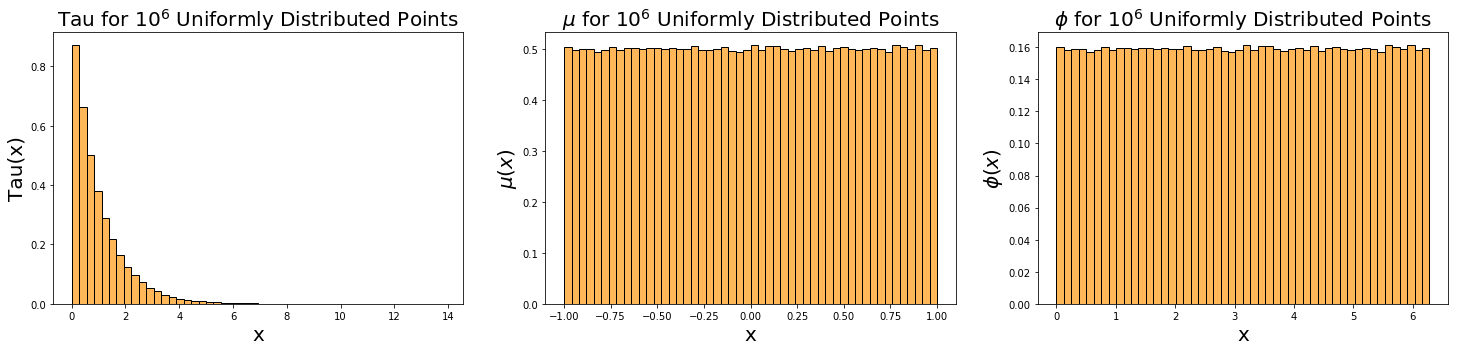

In [4]:
%matplotlib inline
u = np.random.rand(10**6)

fig, ax = plt.subplots(1,3, figsize=(25,5))
ax[0].set_title('Tau for $10^6$ Uniformly Distributed Points', fontsize=20)
ax[0].hist(tau(u), color="#ffb759", ec='black', bins=50, normed=True)
ax[0].set_ylabel('Tau(x)', fontsize=20)
ax[0].set_xlabel('x', fontsize=20)

ax[1].hist(mu(u), color="#ffb759", ec='black', bins=50, normed=True)
ax[1].set_xlabel('x', fontsize=20)
ax[1].set_ylabel('$\mu(x)$', fontsize=20)
ax[1].set_title('$\mu$ for $10^6$ Uniformly Distributed Points', fontsize=20)

ax[2].hist(phi(u), color="#ffb759", ec='black', bins=50, normed=True)
ax[2].set_xlabel('x', fontsize=20)
ax[2].set_ylabel('$\phi(x)$', fontsize=20)
ax[2].set_title('$\phi$ for $10^6$ Uniformly Distributed Points', fontsize=20);


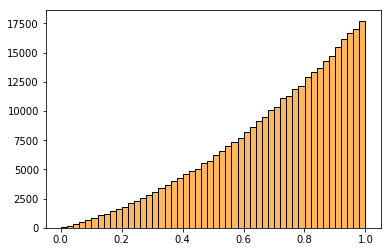

In [5]:
n_particles = 10**6
m, p = mu(np.random.rand(n_particles)), phi(np.random.rand(n_particles))
exited = RT_optimized(m, p, verbose=True)

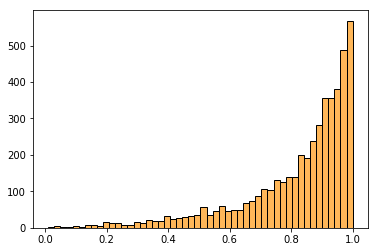

In [6]:
n_particles = 5*10**6
m, p = mu(np.random.rand(n_particles)), phi(np.random.rand(n_particles))
exited = RT_optimized(m, p, prob=0.5, verbose=True)

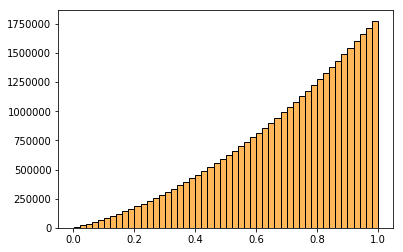

In [9]:
# This will take approx. 30 mins to run on an i7-6700HQ with 16 GB of ram.
# If you have less than 9 GB of ram free on your system before running this,
# be extremely wary of runtime since your computer may start swapping memory.
%matplotlib inline
IwantToWaitAWhile = False
if IwantToWaitAWhile:
    n_particles = 10**8
    m, p = mu(np.random.rand(n_particles)), phi(np.random.rand(n_particles))
    exited = RT_optimized(m, p, verbose=True)
    np.save("exited-prob=1", exited)

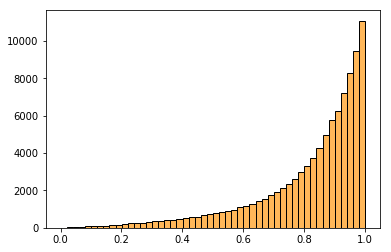

In [10]:
# This will take approx. 30 mins to run on an i7-6700HQ with 16 GB of ram.
# If you have less than 8 GB of ram free on your system before running this,
# be extremely wary of runtime since your computer may start swapping memory.
%matplotlib inline
IwantToWaitAWhile = False
if IwantToWaitAWhile:
    m, p = mu(np.random.rand(n_particles)), phi(np.random.rand(n_particles))
    exited = RT_optimized(m, p, prob=0.5, verbose=True)
    np.save("exited-prob=0.5", exited)

In [5]:
# Even loading the files will take several minutes
# due to the size of the files (especially prob=1)
# Be wary if your computer doesn't have ~1gb of ram available
IwantToWaitAWhile = False
if IwantToWaitAWhile:
    exited_prob_1 = np.load("exited-prob=1")
    exited_prob_half = np.loadtxt("exited-prob=0.5")

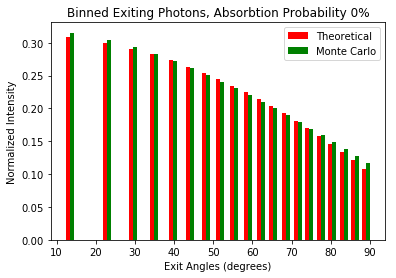

In [10]:
%matplotlib inline
bin_size, intensities, thetas = intensity(exited_prob_1)
thetas = thetas*180/np.pi # Convert from radians to degrees for comparison
theoretical = theoretical_intensity(thetas) # Will normalize to get same normalization constants

#**********Plotting**********
fig, ax = plt.subplots()
width = 1
ax.bar(thetas, theoretical/np.linalg.norm(theoretical), color='r', width=width, label="Theoretical");
ax.bar(thetas+width, intensities/np.linalg.norm(intensities), color='g', width=width, label="Monte Carlo");
ax.set_ylabel("Normalized Intensity")
ax.set_xlabel("Exit Angles (degrees)")
ax.set_title("Binned Exiting Photons, Absorbtion Probability 0%")
ax.legend();

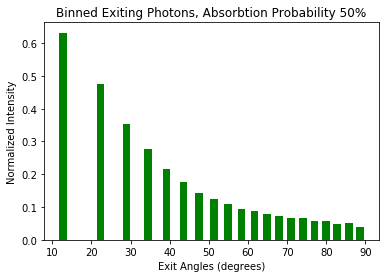

In [9]:
%matplotlib inline
bin_size, intensities, thetas = intensity(exited_prob_half)
thetas = thetas*180/np.pi # Convert from radians to degrees for comparison

#**********Plotting**********
fig, ax = plt.subplots()
width = 1
ax.bar(thetas, intensities/np.linalg.norm(intensities), color='g', width=2)
ax.set_ylabel("Normalized Intensity")
ax.set_xlabel("Exit Angles (degrees)")
ax.set_title("Binned Exiting Photons, Absorbtion Probability 50%");